In [3]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics 

In [29]:
def get_fake_grad(mask=None, signal_scaling=None, noise_strength=1):
    """
    If signal location and or scaling is provided,import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics  then we just vary the noise per function call. 
    Otherwise, generate new signal location/scaling each call
    """
    if mask is None:
        mask = torch.bernoulli(torch.rand(10, 10))
    if signal_scaling is None:
        signal_scaling = torch.randn(10,10)
    signal = signal_scaling*mask
    noise = noise_strength*torch.randn(10, 10)
    
    return signal, noise, mask

def plot_time_series(series, skip=1):
    plt.figure(figsize=(20,12))
    series = np.array(series) 
    series = series.reshape((-1, series[0].size))[:,::skip] #unroll
    plt.plot(series)
    plt.show()
    
def run_simulation(mask=None, signal_scaling=None, noise_strength=1, steps=1000):
    W = nn.Parameter(torch.zeros(10, 10))
    optimizer = torch.optim.Adam([W])

    avg_t = []
    avg_sq_t = []
    avg_v = []
    avg_s = []
    grads = []
    noisy_grads = []
    masks = []
    v = torch.zeros(10,10)
    s = torch.zeros(10,10)
    b1 = 0.9
    b2 = 0.999

    for i in range(steps):
        optimizer.zero_grad()
        signal, noise, sl = get_fake_grad(mask, signal_scaling, )
        masks.append(sl)

        W.grad = signal + noise
        grads.append(signal.numpy())
        noisy_grads.append(signal.numpy() + noise.numpy())

        optimizer.step()
        opt_state = optimizer.state[W]
        avg_t.append(np.copy(opt_state['exp_avg'].numpy()))
        avg_sq_t.append(np.copy(opt_state['exp_avg_sq'].numpy()))    

        v = b1*v + (1-b1)*signal
        s = b2*s + (1-b2)*signal*signal
        avg_v.append(np.copy(v.numpy()))
        avg_s.append(np.copy(s.numpy()))
        
    return avg_t, avg_sq_t, avg_v, avg_s, grads, noisy_grads, masks

def compute_snr(avg_t, avg_sq_t, evolution=True):
    if evolution:
        return [avg_t[i]/avg_sq_t[i] for i in range(len(avg_t))]
    return avg_t[-1]/avg_sq_t[-1]

def show_f1_evolution(y_true, pred, threshold, y_true_fixed=True, plot=True):
    f1_evolution = []
    N = len(pred)
    y_true_i = y_true 
    
    for i in range(N):
        if not y_true_fixed:
            y_true_i = y_true[i]
            
        y_pred_i = (np.abs(pred[i]) > threshold) + 0 # convert boolean to int
        f1_evolution.append(sklearn.metrics.f1_score(y_true_i.flatten(), y_pred_i.flatten()))
        
    mean_f1, max_f1 = np.mean(f1_evolution), np.max(f1_evolution)
    if plot:
        plt.plot(f1_evolution)
        plt.show()
        print('threshold', threshold, 'mean f1', mean_f1, 'max f1', max_f1)
    return mean_f1, max_f1

def select_threshold(thresholds, masks, signal_pred, plt_type='abs(W)', plot_f1_thresholds=True):
    means = []
    maxes = []
    for t in thresholds:
        mean_f1, max_f1 = show_f1_evolution(masks, signal_pred, t, plot=False)
        means.append(mean_f1)
        maxes.append(max_f1)
    if plot_f1_thresholds:
        plt.figure(figsize=(15,10))
        plt.plot(thresholds, means, label='mean')
        plt.plot(thresholds, maxes, label='max')
        plt.legend(loc='best')
        plt.xlabel('thresholds')
        plt.title(f'F1 at varying thresholds for {plt_type}')
        plt.show()
    return means, maxes

In [38]:
# N = 10
# p = int(N*N*0.2)
# k = 0
# mini_count = 0 # tracks if there's been k iterations yet
# for i in range(2):
#     if mini_count == k:
#         mini_count = 0
#         k = torch.randint(1, 100) # TODO: tune
#         idx = torch.arange(N*N)
#         subidx = torch.shuffle(idx)[:p]
        
#         mask = torch.zeros(N*N)
#         mask[subidx] = torch.shuffle(idx)[:p]
#         mask.reshape(N, N)
#         sign = torch.sign(torch.randn(10, 10))
        
# strength = torch.randn(10, 10) * mask
# signal = sign*mask*torch.abs(strength)
# W.grad = signal + noise


In [10]:
# fixed gradient signal location and scaling throughout simulation but noise changes
# signal_location_fixed = torch.bernoulli(torch.rand(10, 10))
# signal_scaling_fixed = None # torch.randn(10,10)
# avg_t_fixed_signal_location, avg_sq_t_fixed_signal_location, avg_vf, avg_sf, gradsf, noisy_grads_fixed_signal_location, _ = run_simulation(
#     signal_location=signal_location_fixed, signal_scaling=signal_scaling_fixed, noise_strength=1)

In [33]:
torch.bernoulli(torch.rand(10, 10)).sum()

tensor(49.)

In [35]:
signal_location_fixed = None
signal_scaling_fixed = None 
avg_t_fixed_signal_location, avg_sq_t_fixed_signal_location, avg_vf, avg_sf, gradsf, noisy_grads_fixed_signal_location, signal_locations = run_simulation(
    signal_location=signal_location_fixed, signal_scaling=signal_scaling_fixed, noise_strength=10)

In [34]:
len(signal_locations)

1000

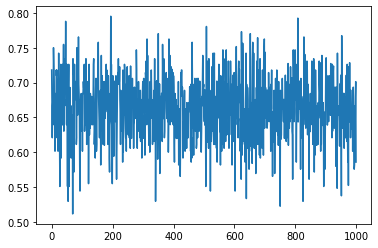

threshold 0.01 mean f1 0.6630854215738597 max f1 0.7951807228915663


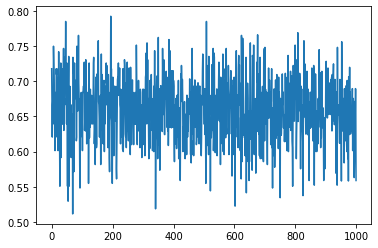

threshold 0.02 mean f1 0.6599185108058584 max f1 0.7926829268292682


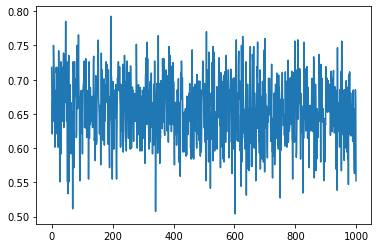

threshold 0.03 mean f1 0.6565692542608256 max f1 0.7926829268292682


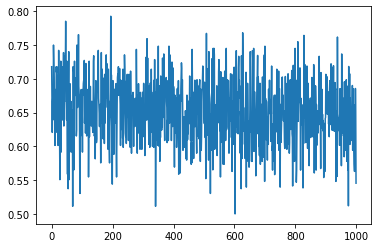

threshold 0.04 mean f1 0.6531709667358779 max f1 0.7926829268292682


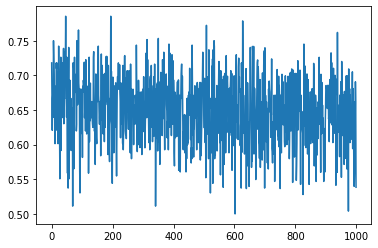

threshold 0.05 mean f1 0.6498261356015786 max f1 0.7852760736196319


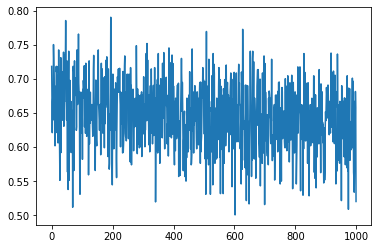

threshold 0.06 mean f1 0.6458788057282261 max f1 0.7901234567901234


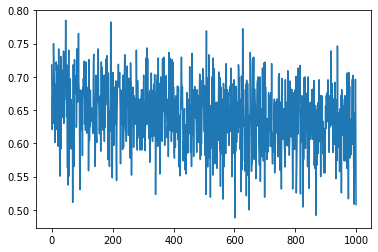

threshold 0.07 mean f1 0.6421806542011474 max f1 0.7852760736196319


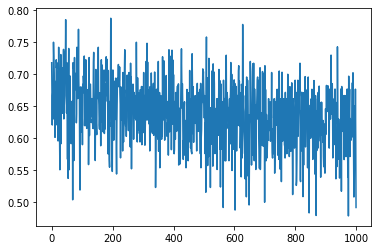

threshold 0.08 mean f1 0.63852855601004 max f1 0.7875000000000001


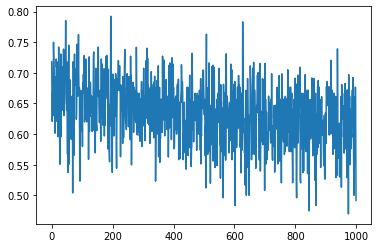

threshold 0.09 mean f1 0.6346427204676868 max f1 0.7924528301886793


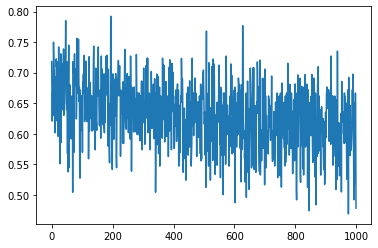

threshold 0.1 mean f1 0.6305052811217988 max f1 0.7924528301886793


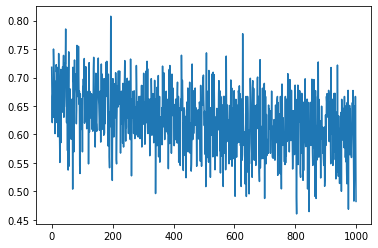

threshold 0.11 mean f1 0.6263726208029545 max f1 0.8076923076923077


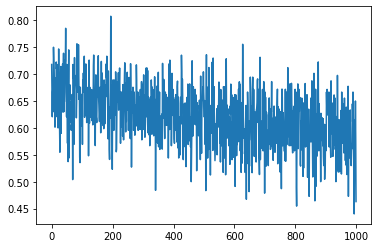

threshold 0.12 mean f1 0.6213849735134229 max f1 0.8076923076923077


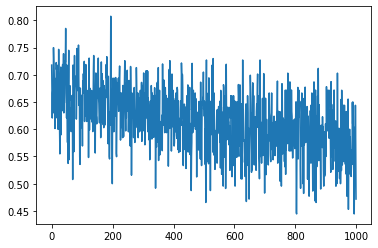

threshold 0.13 mean f1 0.6169009447418291 max f1 0.8076923076923077


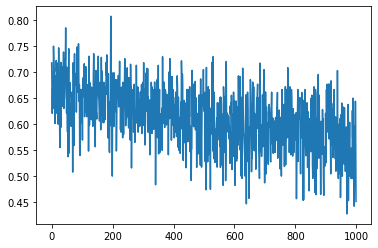

threshold 0.14 mean f1 0.6124835932487527 max f1 0.8076923076923077


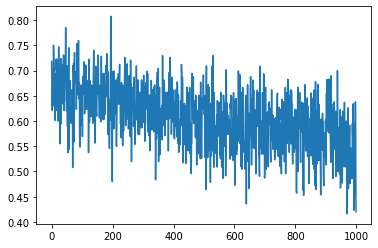

threshold 0.15 mean f1 0.6081201016978138 max f1 0.8076923076923077


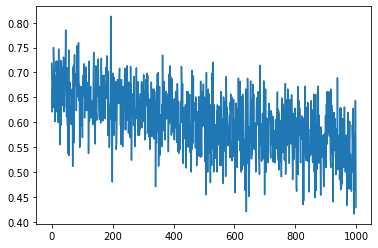

threshold 0.16 mean f1 0.6037315241298801 max f1 0.8129032258064516


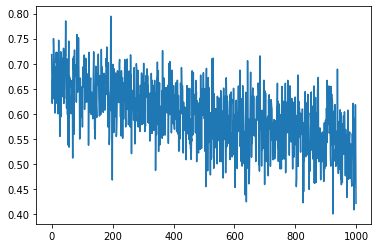

threshold 0.17 mean f1 0.5987634277920454 max f1 0.794701986754967


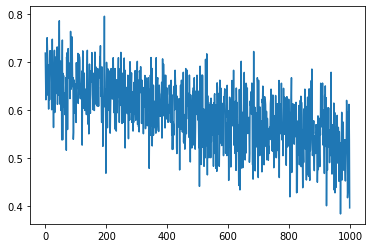

threshold 0.18 mean f1 0.5937870667749634 max f1 0.794701986754967


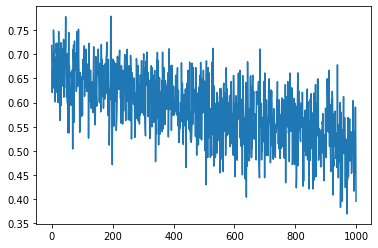

threshold 0.19 mean f1 0.5882518678159541 max f1 0.778523489932886


In [36]:
adam_snr_fixed_signal_location = compute_snr(avg_t_fixed_signal_location, avg_sq_t_fixed_signal_location)
for i in range(1,20):
    show_f1_evolution(signal_locations, adam_snr_fixed_signal_location, 0.01*i, y_true_fixed=False)

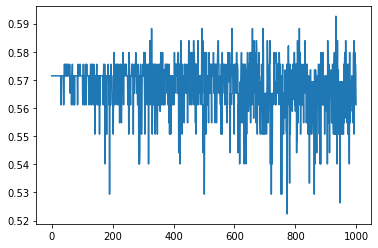

threshold 0.01 mean f1 0.5672405144338182 max f1 0.5925925925925926


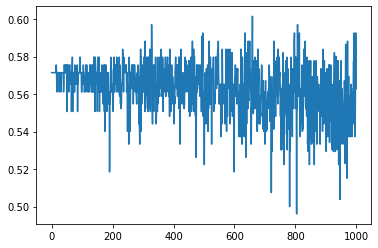

threshold 0.02 mean f1 0.5630717074902657 max f1 0.6015037593984962


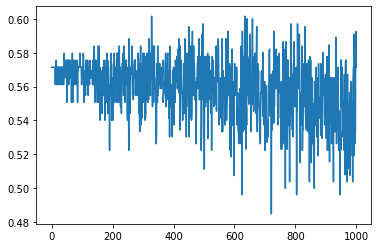

threshold 0.03 mean f1 0.5590288424994169 max f1 0.6015037593984962


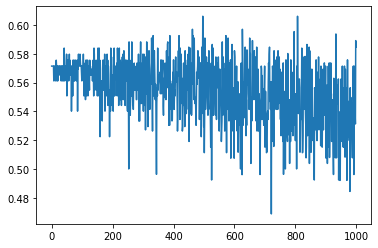

threshold 0.04 mean f1 0.5544634675200336 max f1 0.6060606060606061


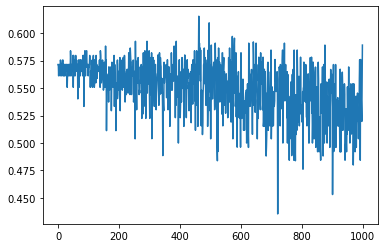

threshold 0.05 mean f1 0.5494540264468303 max f1 0.6153846153846153


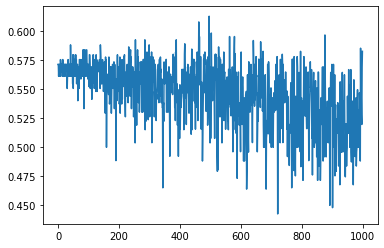

threshold 0.06 mean f1 0.5452631320120569 max f1 0.6129032258064516


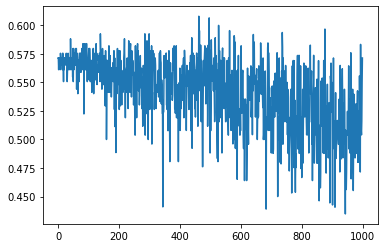

threshold 0.07 mean f1 0.5409031732407161 max f1 0.608


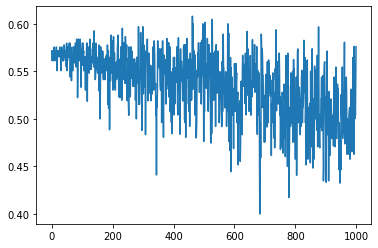

threshold 0.08 mean f1 0.5362078279206588 max f1 0.608


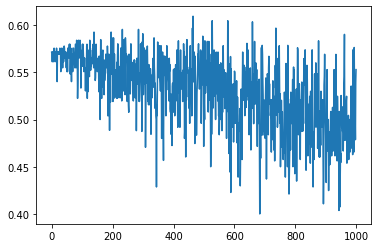

threshold 0.09 mean f1 0.5305591099912323 max f1 0.6093749999999999


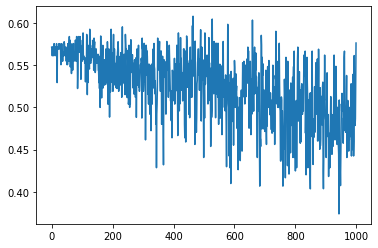

threshold 0.1 mean f1 0.5247605879013565 max f1 0.608


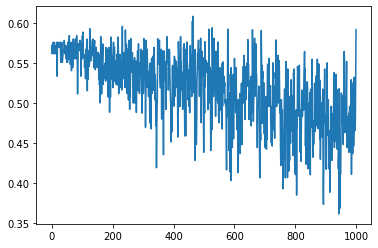

threshold 0.11 mean f1 0.5197247014560039 max f1 0.608


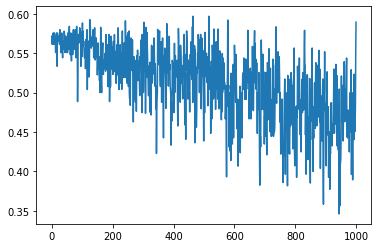

threshold 0.12 mean f1 0.5141028481955561 max f1 0.5967741935483871


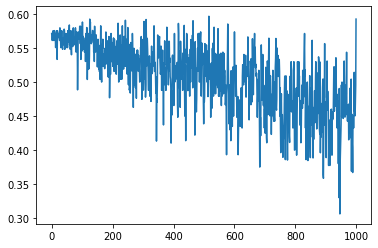

threshold 0.13 mean f1 0.5079941647187315 max f1 0.5967741935483871


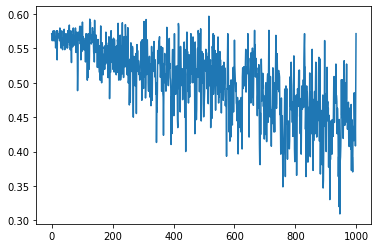

threshold 0.14 mean f1 0.5029579306873522 max f1 0.5967741935483871


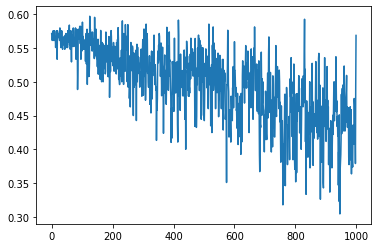

threshold 0.15 mean f1 0.4972489059140978 max f1 0.5970149253731344


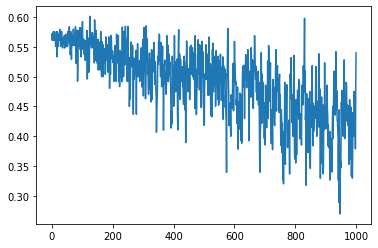

threshold 0.16 mean f1 0.49114224741411905 max f1 0.6015037593984962


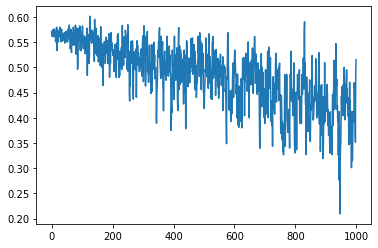

threshold 0.17 mean f1 0.4859925541936594 max f1 0.6015037593984962


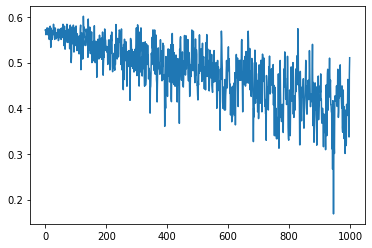

threshold 0.18 mean f1 0.4805846572336071 max f1 0.6015037593984962


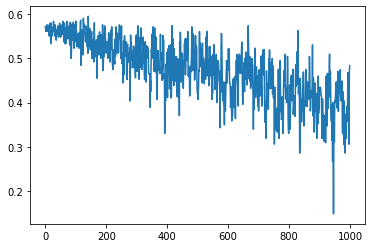

threshold 0.19 mean f1 0.47504958061995445 max f1 0.5954198473282443


In [27]:
adam_snr_fixed_signal_location = compute_snr(avg_t_fixed_signal_location, avg_sq_t_fixed_signal_location)
for i in range(1,20):
    show_f1_evolution(signal_location_fixed, adam_snr_fixed_signal_location, 0.01*i)

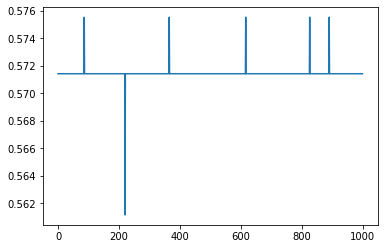

threshold 0.0001 mean f1 0.5714388489208633 max f1 0.5755395683453237


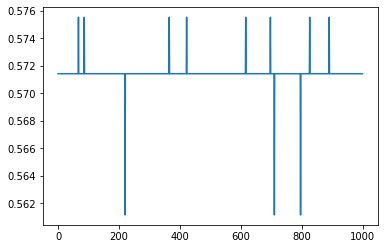

threshold 0.0002 mean f1 0.5714306269270298 max f1 0.5755395683453237


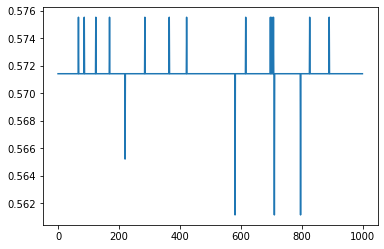

threshold 0.00030000000000000003 mean f1 0.5714449707314894 max f1 0.5755395683453237


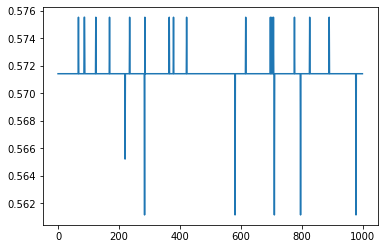

threshold 0.0004 mean f1 0.5714408597345726 max f1 0.5755395683453237


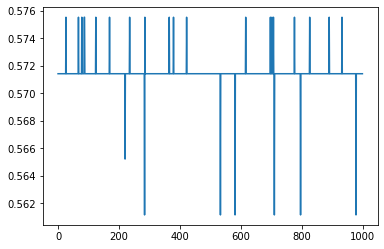

threshold 0.0005 mean f1 0.5714429152330309 max f1 0.5755395683453237


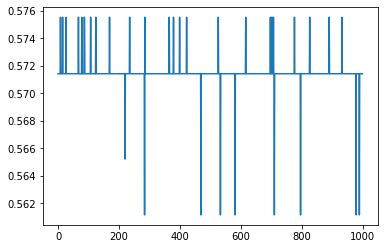

threshold 0.0006000000000000001 mean f1 0.571442915233031 max f1 0.5755395683453237


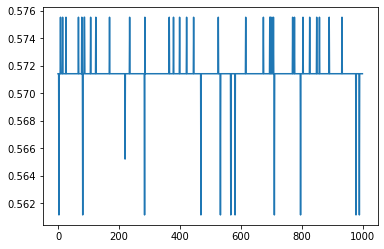

threshold 0.0007 mean f1 0.5714408597345726 max f1 0.5755395683453237


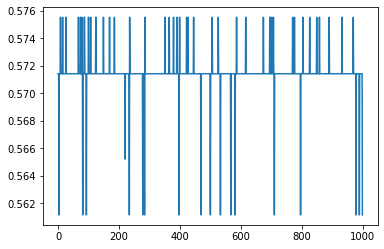

threshold 0.0008 mean f1 0.5714203047499887 max f1 0.5755395683453237


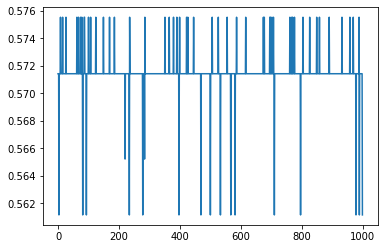

threshold 0.0009000000000000001 mean f1 0.5714531480405738 max f1 0.5755395683453237


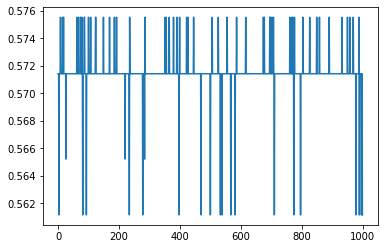

threshold 0.001 mean f1 0.5714325483712408 max f1 0.5755395683453237


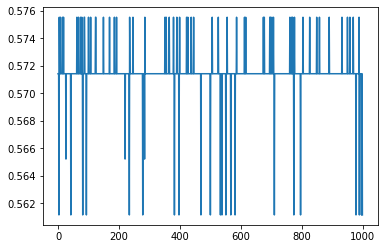

threshold 0.0011 mean f1 0.5714181598820323 max f1 0.5755395683453237


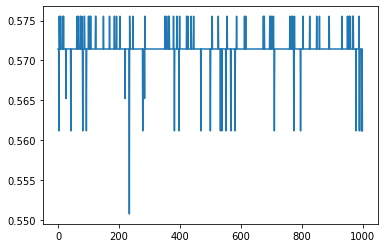

threshold 0.0012000000000000001 mean f1 0.5714282884251605 max f1 0.5755395683453237


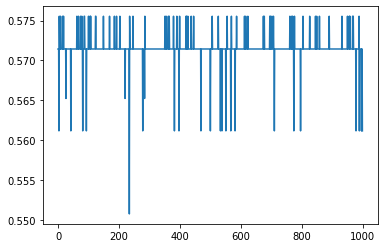

threshold 0.0013000000000000002 mean f1 0.5714447324128276 max f1 0.5755395683453237


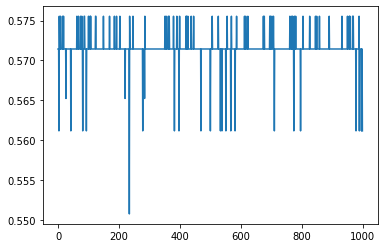

threshold 0.0014 mean f1 0.5714488434097443 max f1 0.5755395683453237


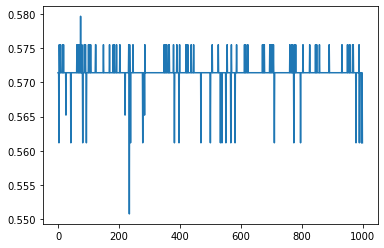

threshold 0.0015 mean f1 0.5714674024755351 max f1 0.5797101449275363


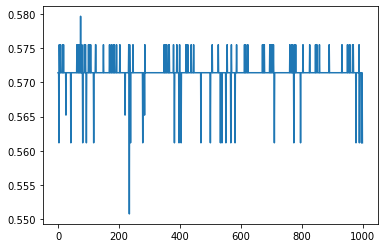

threshold 0.0016 mean f1 0.5714550694847849 max f1 0.5797101449275363


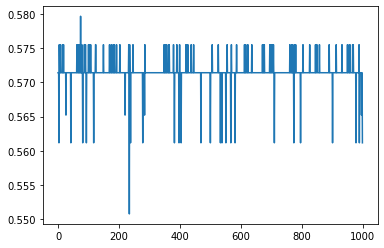

threshold 0.0017000000000000001 mean f1 0.5714570802984942 max f1 0.5797101449275363


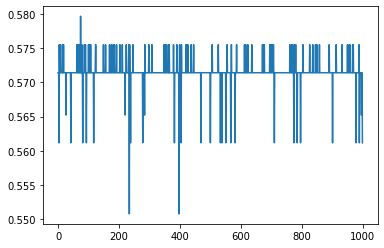

threshold 0.0018000000000000002 mean f1 0.571465153343164 max f1 0.5797101449275363


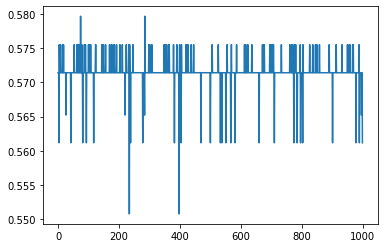

threshold 0.0019 mean f1 0.5714734349166629 max f1 0.5797101449275363


In [20]:
for i in range(1,20):
    t = 0.0001*i
    mean_f1, max_f1 = show_f1_evolution(signal_location_fixed, noisy_grads_fixed_signal_location, t)

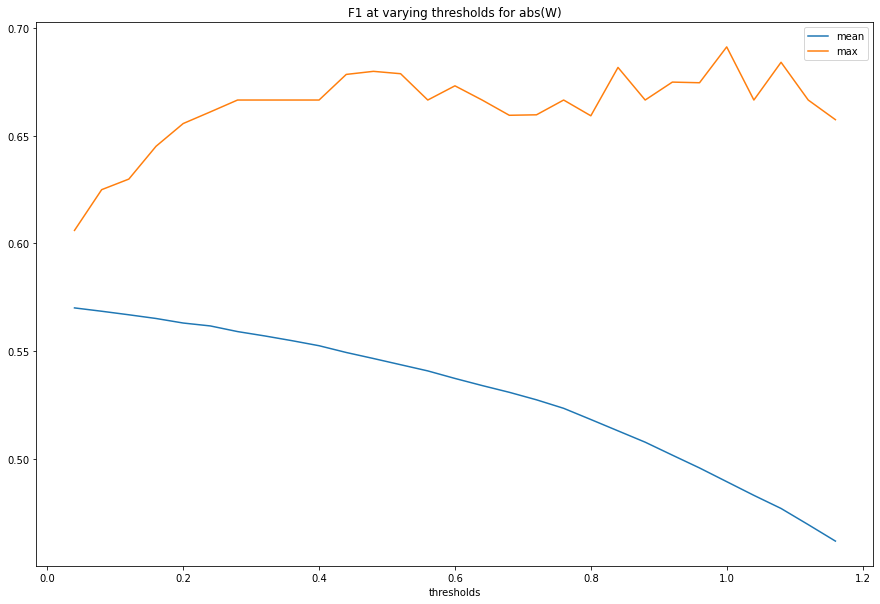

In [25]:
_ = select_threshold([0.04*i for i in range(1,30)], signal_location_fixed, noisy_grads_fixed_signal_location) 
#.02 [signal 10, fixed]

In [26]:
np.linspace(.5,5,10)

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [ ]:
# Selecting 0.1 for grad threshold

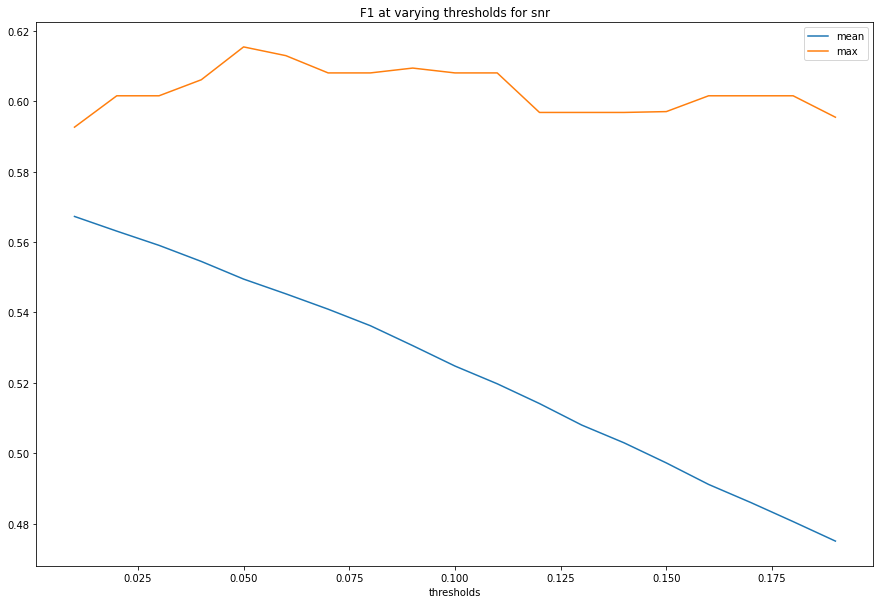

In [23]:
_ = select_threshold([0.01*i for i in range(1,20)], signal_location_fixed, adam_snr_fixed_signal_location, 'snr') 
#.1 [signal 10, fixed]

In [ ]:
# Selecting 0.5 for snr

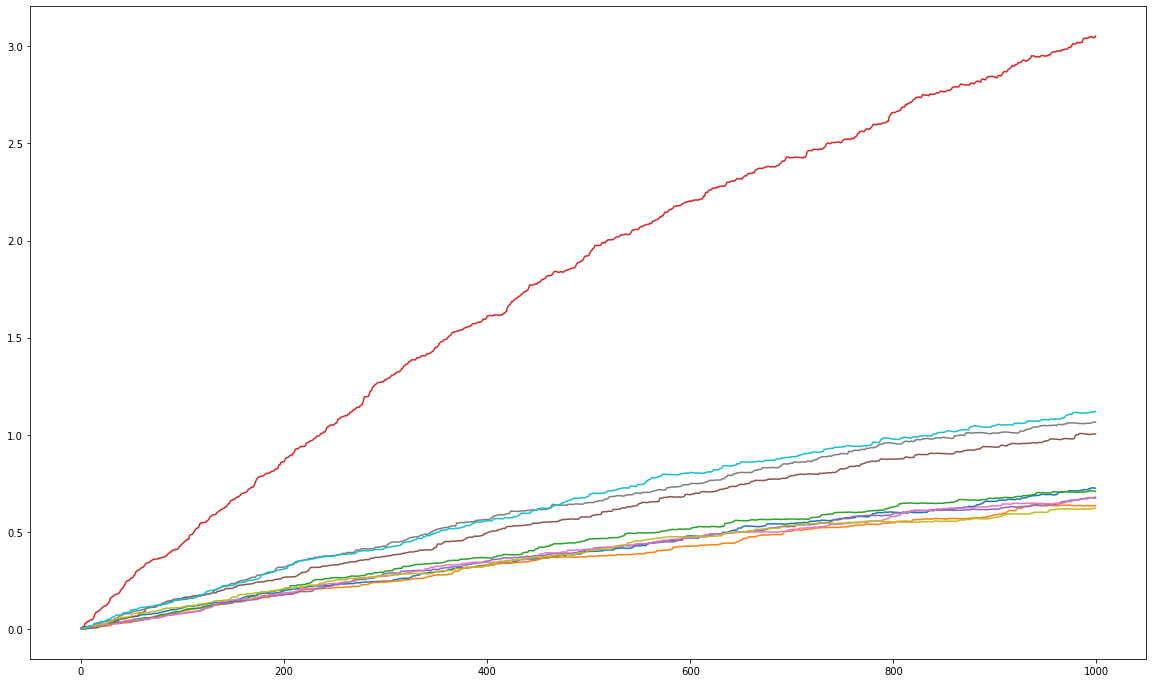

In [33]:
plot_time_series(avg_sq_t_fixed_signal_location, 10)

In [4]:
signal_location_fixed = torch.bernoulli(torch.rand(10, 10))
signal_scaling_fixed = torch.randn(10,10)
noise_strengths = []
thresh_ts = []
snr_ts = []
all_thresh_means = []
all_snr_means = []
all_thresh_maxes = []
all_snr_maxes = []
for noise_strength in np.linspace(0.5, 20, 40):
    print('noise_strength', noise_strength)
    avg_t_fixed_signal_location, avg_sq_t_fixed_signal_location, avg_vf, avg_sf, gradsf, noisy_grads_fixed_signal_location = run_simulation(
        signal_location=signal_location_fixed, signal_scaling=signal_scaling_fixed, noise_strength=noise_strength)
    
    noise_strengths.append(noise_strength)
    
    thresh_t = [0.02*i for i in range(1,30)]
    thresh_means, thresh_maxes = select_threshold(thresh_t, signal_location_fixed, 
                                                  noisy_grads_fixed_signal_location, plot_f1_thresholds=False)
    thresh_ts.append(thresh_t)
    all_thresh_means.append(thresh_means)
    all_thresh_maxes.append(all_thresh_maxes)
    
    snr_t = [0.1*i for i in range(1,20)]
    adam_snr_fixed_signal_location = compute_snr(avg_t_fixed_signal_location, avg_sq_t_fixed_signal_location)
    snr_means, snr_maxes = select_threshold(snr_t, signal_location_fixed, 
                                            adam_snr_fixed_signal_location, 'snr', plot_f1_thresholds=False)
    snr_ts.append(snr_t)
    all_snr_means.append(snr_means)
    all_snr_maxes.append(snr_maxes)

noise_strength 0.5
noise_strength 1.0
noise_strength 1.5
noise_strength 2.0
noise_strength 2.5
noise_strength 3.0
noise_strength 3.5
noise_strength 4.0
noise_strength 4.5
noise_strength 5.0
noise_strength 5.5
noise_strength 6.0
noise_strength 6.5
noise_strength 7.0
noise_strength 7.5
noise_strength 8.0
noise_strength 8.5
noise_strength 9.0
noise_strength 9.5
noise_strength 10.0
noise_strength 10.5
noise_strength 11.0
noise_strength 11.5
noise_strength 12.0
noise_strength 12.5
noise_strength 13.0
noise_strength 13.5
noise_strength 14.0
noise_strength 14.5
noise_strength 15.0
noise_strength 15.5
noise_strength 16.0
noise_strength 16.5
noise_strength 17.0
noise_strength 17.5
noise_strength 18.0
noise_strength 18.5
noise_strength 19.0
noise_strength 19.5
noise_strength 20.0


In [2]:
np.save('noise_strengths_fixed', noise_strengths)
print('done noise_strengths_fixed')
np.save('thresh_ts_fixed', thresh_ts)
print('done thresh_ts_fixed')
np.save('snr_ts', snr_ts)
print('done snr_ts')
np.save('all_thresh_means', all_thresh_means)
print('done all_thresh_means')
np.save('all_snr_means', all_snr_means)
print('done all_snr_means')
np.save('all_thresh_maxes', all_thresh_maxes)
print('done all_thresh_maxes')
np.save('all_snr_maxes', all_thresh_maxes)
print('done all_snr_maxes')

NameError: name 'np' is not defined

In [1]:
print('hello')

hello


In [67]:
np.linspace(0.5, 20, 40)

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5,
       17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ])

In [45]:
noise_strengths
thresh_ts
snr_ts
all_thresh_means
all_snr_means
all_thresh_maxes
all_snr_maxes

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
len(all_snr_maxes)

In [51]:
noise_strengths

[0, 1]

In [57]:
len(snr_ts)

20

In [ ]:
# meshgrid_noise_strength = [[i for j in range(1,20)] for i in noise_strengths]
# fig = plt.figure(figsize=(20,15))
# ax = plt.axes(projection='3d')
# ax.contour3D(np.array(snr_ts), np.array(meshgrid_noise_strength), np.array(all_snr_maxes), 50, cmap='jet')
# ax.set_xlabel('thresholds')
# ax.set_ylabel('noise_strength')
# ax.set_zlabel('max f1');
# ax.set_title('SNR')

In [ ]:
meshgrid_noise_strength = [[i for j in range(1,30)] for i in noise_strengths]
fig = plt.figure(figsize=(20,15))
ax = plt.axes(projection='3d')
ax.contour3D(np.array(thresh_ts), np.array(meshgrid_noise_strength), np.array(all_thresh_maxes), 50, cmap='jet')
ax.set_xlabel('thresholds')
ax.set_ylabel('noise_strength')
ax.set_zlabel('max f1');
ax.set_title('Threshold')

In [ ]:
# Plots to share: [Save code for generation and actual csvs to use in case of a paper. also code to export to table]
# At fixed position
# 1. mean/max f1 over time per hyperparameter selection
# 2. some plots of evolution of f1 over time
# 3. same plot as 1 but with changing signal strength. can we make a 3d plot out of it?
# 4. use variable signal position
# 5. select different noise type
# stretch: investigate evolution of threshold
# stretch: compare that self momentum without noise is same as adam momentum without noise

In [416]:
# only_signal_momentum_snr_fixed_signal_location = compute_snr(avg_vf, avg_sf)
# for i in range(1,11):
#     show_f1_evolution(signal_location_fixed, only_signal_momentum_snr_fixed_signal_location, 0.0001*i)

In [417]:
# plot_time_series(noisy_grads, 100)

In [418]:
# plot_time_series(grads, 100)

In [ ]:
# TODO: write code to do ema [DONE]
# b1 = 0.9
# b2 = 0.999
# g = avg_t[-1]
# v = b1*v + (1-b1)*g
# s = b2*s + (1-b2)*g*g

# write snr [DONE]
# write correlation b/n adam avgs and pure signal avgs [DONE]
# compare adam signal to threshold signal [DONE]

In [ ]:
# locate SNR at points of signals and compare with point of absence  [DONE]                    
# for dynamic gradients (bernoulli changing over time), plot the average location of 1s to see if some are stable
# an easier start would be to start with both bernoulli and scaling fixed then
# keep the bernoulli fixed but scaling variable

In [419]:
# snr_ = optimizer.state[W]['exp_avg'].numpy()/optimizer.state[W]['exp_avg_sq'].numpy()
# print(np.mean(snr_), np.median(snr_))

In [222]:
import pandas as pd

In [225]:
snr_df = pd.DataFrame(snr_)

In [ ]:
# plot_time_series(avg_sq_tf, 2)
# plot_time_series(avg_tf, 2)
# (sl_f.numpy()==1).sum()
# snr_ = compute_snr(avg_tf, avg_sq_tf)
# (np.abs(snr_[sl_f.numpy()==0]) > t_snr).sum()
# (np.abs(snr_[sl_f.numpy()==1]) > t_snr).sum()

# compute f1 stat (how well are we detecting signal vs noise - true positive vs false positive detection)
# y_true = sl_f.numpy()
# y_pred_adam = (snr_ > t_snr) + 0 # convert boolean to int
# y_pred_threshold = (np.abs(noisy_grads[-1]) > threshold) + 0

# plot_time_series(avg_t, 100)
# plot_time_series(avg_sq_t, 25)

# plot_time_series(avg_v, 100)
# plot_time_series(avg_s, 50)

Try a few varied signal types: bernoulli, poisson, salt & pepper, etc
Vary the signal strength relative to the noise

Baseline, threshold
Gold standard, compute SNR based off mean of signal and variance of noise [double check]